In [34]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
words = open('names.txt', 'r').read().splitlines()

In [36]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [37]:
len(words)

32033

In [38]:
chars = sorted(list(set(''.join(words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [39]:
def buildDataset(words):
    block_size = 3
    x, y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            #print(''.join ([itos[i] for i in context]), '-->', itos[ix])
            context = context[1:] + [ix]
            
    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape, y.shape)
    return x, y
import random
random.seed(42)
random.shuffle(words)
n1 = int (len(words)*.8)    
n2 = int (len(words)*.9)    
x_train, y_train = buildDataset(words[:n1])
x_val, y_val = buildDataset(words[n1:n2])
x_test, y_test = buildDataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [40]:
n_embd = 10
n_hidden = 200
block_size = 3

C = torch.randn(len(itos), n_embd)
W1 = torch.randn(n_embd * block_size, n_hidden)
B1 = torch.randn(n_hidden)
W2 = torch.randn(n_hidden, len(itos))
B2 = torch.randn(len(itos))
params = [C, W1, B1, W2, B2]
for p in params:
    p.requires_grad = True

In [41]:
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, len(x_train), (batch_size,))
    Xb = x_train[ix]
    Yb = y_train[ix]
    
    emb = C[Xb]
    embcat = emb.view(emb.size(0), -1)
    hpreact = embcat @ W1 + B1
    h = hpreact.tanh()
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Yb)
    
    for p in params:
        p.grad = None
    loss.backward()
    
    lr = .1
    for p in params:
        p.data -= lr * p.grad
    
        
    if i % 1000 == 0:
        print(i, loss.item())
        lr *= .98
    lossi.append(loss.log10().item())

0 27.487613677978516
1000 3.83536696434021
2000 3.4701476097106934
3000 2.755993127822876
4000 2.204185962677002
5000 3.515378713607788
6000 2.7417266368865967
7000 2.6073501110076904
8000 2.403043031692505
9000 2.741934299468994
10000 2.3660356998443604
11000 2.9752824306488037
12000 3.029843330383301
13000 2.248863935470581
14000 2.5635836124420166
15000 2.2559902667999268
16000 2.301504373550415
17000 2.6802496910095215
18000 2.358865976333618
19000 1.790012001991272
20000 2.3447651863098145
21000 3.196031332015991
22000 2.5080392360687256
23000 2.53584885597229
24000 2.676246166229248
25000 2.373739242553711
26000 2.356323719024658
27000 2.5191047191619873
28000 2.208317756652832
29000 2.4634406566619873
30000 2.081185817718506
31000 2.284024238586426
32000 1.8584388494491577
33000 2.6186606884002686
34000 2.085904836654663
35000 1.640205979347229
36000 2.0802340507507324
37000 2.75677227973938
38000 2.40325665473938
39000 2.1253502368927
40000 2.297633647918701
41000 2.25726938247

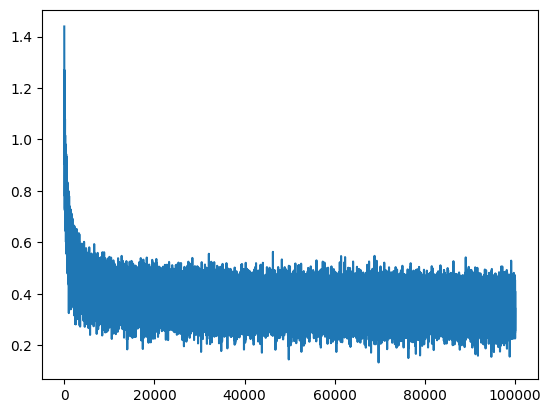

In [42]:
plt.plot(lossi)

In [43]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (x_train, y_train),
        'val': (x_val, y_val),
        'test': (x_test, y_test)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.size(0), -1)
    h = torch.tanh(embcat @ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')
    

train 2.287203788757324
val 2.314033031463623
